dataset: https://drive.google.com/file/d/18aMf57_1u2AWInnMB67s3Xku0sPzm28u/view

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm

#for Data preprocessing and Augmentation
import os
from imutils import paths
import cv2
# import Augmentor
import torchvision.transforms as transforms

#for reading and displaying images
import matplotlib.pyplot as plt
from PIL import Image

#Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

#torchvision for pre-trained models
import torchvision
from torchvision import datasets, models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
# from sklearn.model_selection import KFold


# Setting

In [2]:
BATCH_SIZE = 8
INIT_LR = 1e-3
classes = ['Normal', 'Covid']
num_classes = 2
num_epochs = 15
criterion = CrossEntropyLoss()
CHECKPOINT_PATH = './FT_VGG16_8.pt'
path_dataset = '../dataset10K_images/'

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Path dataset

In [3]:
normal = path_dataset + 'NORMAL/'
covid = path_dataset + 'COVID/'

dir_normal = os.listdir(normal)
dir_covid = os.listdir(covid)

# dataset = np.concatenate(dir_normal, dir_covid, axis = 0)
# dataset
dict_data0 = {'path': normal, 'image_name': dir_normal, 'labels': 0}
dict_data1 = {'path': covid, 'image_name': dir_covid, 'labels': 1}

# len(dict_data['COVID'])


In [4]:
import pandas as pd

df0 = pd.DataFrame(dict_data0)
df1 = pd.DataFrame(dict_data1)
df = pd.concat([df0, df1])
df.to_csv('./data.csv', index = False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        10000 non-null  object
 1   image_name  10000 non-null  object
 2   labels      10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


# Train and test split

In [6]:
train_data, test_data=train_test_split(df, test_size=0.2, random_state = 42, shuffle=True)
train_data, val_data =train_test_split(train_data, test_size=0.2, random_state = 42, shuffle=True)

In [7]:
print(len(train_data), len(val_data), len(test_data))

6400 1600 2000


In [8]:
train_data

,path,image_name,labels
2579,../dataset10K_images/NORMAL/,Normal-1826.png,0
2128,../dataset10K_images/COVID/,COVID-364.png,1
4082,../dataset10K_images/NORMAL/,Normal-931.png,0
2550,../dataset10K_images/NORMAL/,Normal-1799.png,0
4926,../dataset10K_images/NORMAL/,NORMAL2-IM-1204-0001.jpeg,0
...,...,...,...
3871,../dataset10K_images/COVID/,COVID_original_CR.1.2.840.113564.192168196.202...,1
4826,../dataset10K_images/COVID/,COVID1_original_COVID_original_covid-19-pneumo...,1
268,../dataset10K_images/COVID/,COVID-1052.png,1
4666,../dataset10K_images/COVID/,COVID1_original_COVID-1653.png_3c83c6c3-c6b4-4...,1


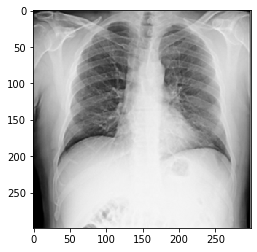

In [9]:
# train_data['image_name'].iloc[0]
train_data['path'].iloc[1] + train_data['image_name'].iloc[1]
image = Image.open(train_data['path'].iloc[1] + train_data['image_name'].iloc[1]).convert('RGB')
plt.imshow(image)

In [10]:
class ImageDataset(Dataset):
    def __init__(self, csv, transform):
        self.transform = transform
        self.csv = csv
        
        self.image_name = self.csv[:]['image_name']
        self.label = np.array(self.csv[:]['labels'])
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index): 
        images = Image.open(self.csv['path'].iloc[index] + self.image_name.iloc[index]).convert('RGB')
        
        images = self.transform(images)
        targets = self.label[index]
        targets = torch.tensor(targets, dtype = torch.long)
#         sample = {'image': image, 'labels': targets}
        
        return images, targets
        

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageDataset(train_data, transform)
val_dataset = ImageDataset(val_data, transform)
test_dataset = ImageDataset(test_data, transform)

train_dataset

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [13]:
# Run this to test the data loader
data, label = next(iter(train_dataloader))
data.size()

# for sample in tqdm(train_dataloader):
#     data = sample['image'].to(device)
#     label = sample['labels'].to(device)

torch.Size([8, 3, 224, 224])

# Build the models

# Using Transfer Learning

In [14]:
# loading the pretrained model
model = models.vgg16(pretrained = True)
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [15]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Remove the pre-trained network's final layers

In [16]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
# numFeatures = model.classifier[0].in_features
# loop over the modules of the model and set the parameters of
# batch normalization modules as not trainable
for module, param in zip(model.modules(), model.parameters()):
    #kiểm tra xem môt đối tượng (tham số thứ nhất) là một instance hay là một lớp con của tham số thứ hai.
    if isinstance(module, nn.BatchNorm2d): 
        param.requires_grad = False
# define the network head and attach it to the model
headModel = nn.Sequential(
#     nn.Linear(numFeatures, 128),
    nn.Linear(8192, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, num_classes)
)
model.classifier = headModel 
# append a new classification top to our feature extractor and pop it
# on to the current device
model = model.to(device)


In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Define  Train the Model using Early Stopping

In [18]:
def training_loop(model, optimizer, loss_list, acc_list):
    model.to(device)
    #List to store loss to visualize
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
    count = 0
    patience = 8 # nếu val_loss tăng 15 lần thì ngừng
    for epoch in range(num_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for data, label in tqdm(train_dataloader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(label).sum().item()
            
#         scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for data, label in tqdm(val_dataloader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(label).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, './VGG16_model8.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
   
                return lossli, accli    
           
    return lossli, accli

In [19]:
#Create the optimizer
params_to_update = model.parameters()
print('Params to learn:')
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t Learn',name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print('\t No',name)
            
optimizer = Adam(params_to_update ,lr = INIT_LR, weight_decay= INIT_LR / num_epochs)


Params to learn:
	 Learn features.0.weight
	 Learn features.0.bias
	 Learn features.2.weight
	 Learn features.2.bias
	 Learn features.5.weight
	 Learn features.5.bias
	 Learn features.7.weight
	 Learn features.7.bias
	 Learn features.10.weight
	 Learn features.10.bias
	 Learn features.12.weight
	 Learn features.12.bias
	 Learn features.14.weight
	 Learn features.14.bias
	 Learn features.17.weight
	 Learn features.17.bias
	 Learn features.19.weight
	 Learn features.19.bias
	 Learn features.21.weight
	 Learn features.21.bias
	 Learn features.24.weight
	 Learn features.24.bias
	 Learn features.26.weight
	 Learn features.26.bias
	 Learn features.28.weight
	 Learn features.28.bias
	 Learn classifier.0.weight
	 Learn classifier.0.bias
	 Learn classifier.2.weight
	 Learn classifier.2.bias
	 Learn classifier.5.weight
	 Learn classifier.5.bias


# Train the Model

In [20]:
loss_list, acc_list = [],[]

since = time.time()

loss, acc = training_loop(
    model = model,
    optimizer = optimizer,
    loss_list = loss_list,
    acc_list = acc_list
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 200/200 [00:35<00:00,  5.61it/s]


Epoch: 0 	Training Loss: 0.511835 	Validation Loss: 0.388659
Validation loss decreased (inf --> 0.388659). Saving model ...
count =  0


100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Epoch: 1 	Training Loss: 0.410012 	Validation Loss: 0.334112
Validation loss decreased (0.388659 --> 0.334112). Saving model ...
count =  0


100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


Epoch: 2 	Training Loss: 0.628010 	Validation Loss: 0.715021


  0%|          | 1/800 [00:00<02:36,  5.10it/s]

count =  1


100%|██████████| 200/200 [00:35<00:00,  5.61it/s]


Epoch: 3 	Training Loss: 0.691649 	Validation Loss: 0.693634


  0%|          | 2/800 [00:00<01:17, 10.27it/s]

count =  2


100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


Epoch: 4 	Training Loss: 0.693281 	Validation Loss: 0.693150


  0%|          | 1/800 [00:00<01:39,  8.00it/s]

count =  3


100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


Epoch: 5 	Training Loss: 0.693273 	Validation Loss: 0.693153


  0%|          | 0/800 [00:00<?, ?it/s]

count =  4


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]


Epoch: 6 	Training Loss: 0.693280 	Validation Loss: 0.693149


  0%|          | 0/800 [00:00<?, ?it/s]

count =  5


100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


Epoch: 7 	Training Loss: 0.693294 	Validation Loss: 0.693150


  0%|          | 1/800 [00:00<02:21,  5.64it/s]

count =  6


100%|██████████| 200/200 [00:35<00:00,  5.68it/s]


Epoch: 8 	Training Loss: 0.693316 	Validation Loss: 0.693148


  0%|          | 1/800 [00:00<01:25,  9.36it/s]

count =  7


100%|██████████| 200/200 [00:35<00:00,  5.68it/s]


Epoch: 9 	Training Loss: 0.693285 	Validation Loss: 0.693173
count =  8
Early stopping!
Training complete in 34m 5s


In [21]:
label.dtype

torch.int64

# load model, state_dict

In [22]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


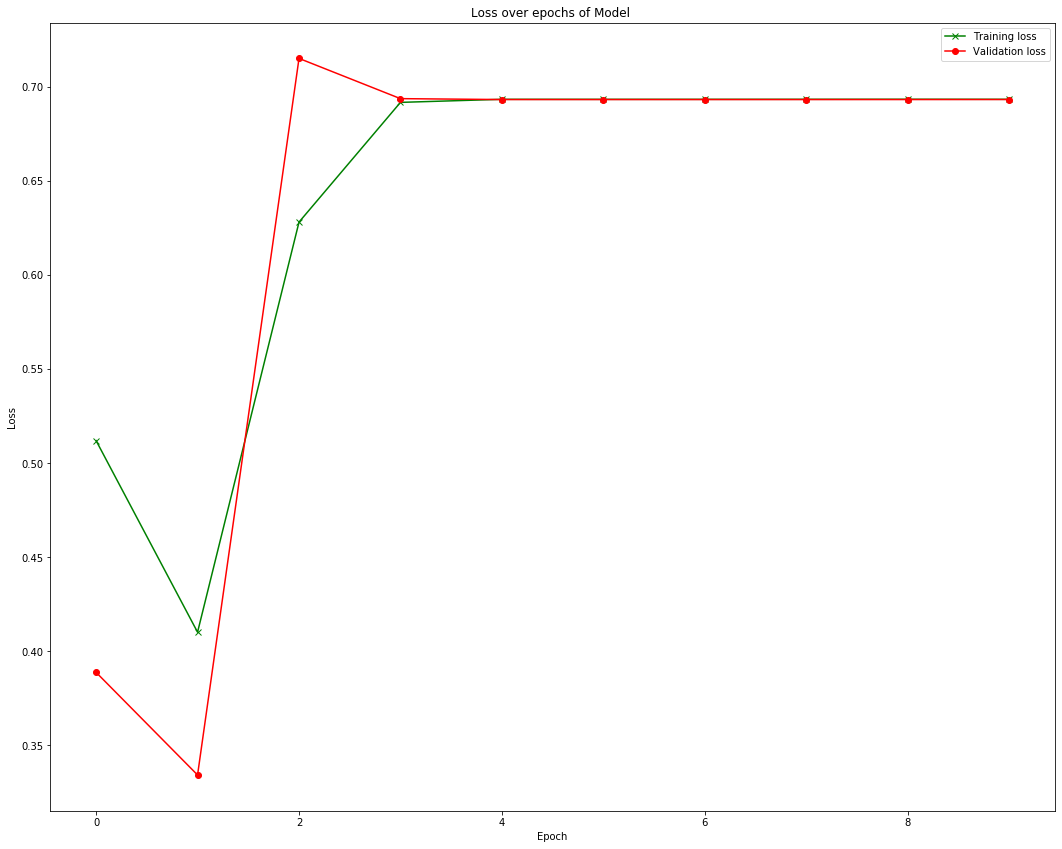

In [23]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, './loss8.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


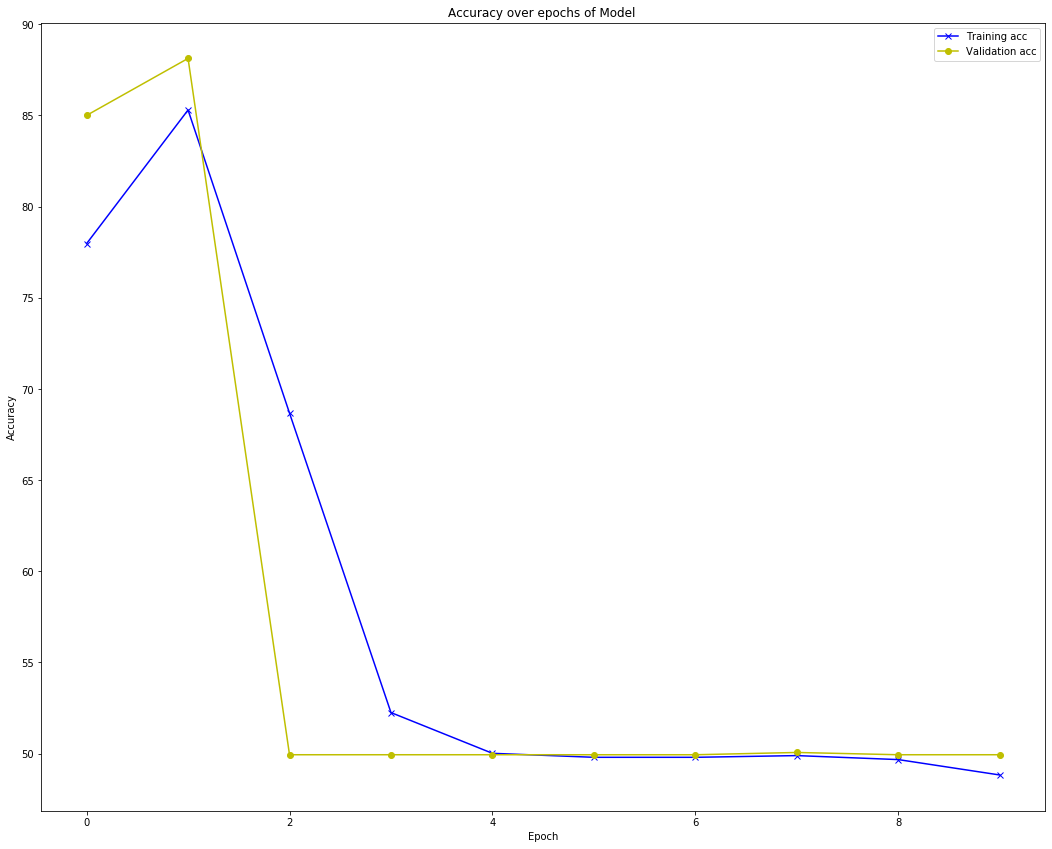

In [24]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, './Accuracy8.png')

In [25]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model.to(device)
        model.eval()
        for data, label in test_dataloader:
            batch_size = data.size(0)
            data = data.to(device)
            target = label.to(device)
            output = model(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [26]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.494

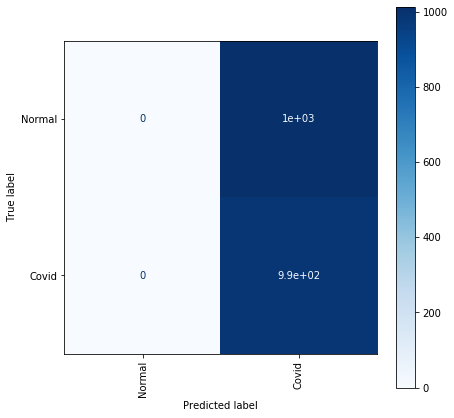

In [27]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'Blues', ax = ax, xticks_rotation = 'vertical')
# disp.plot(include_values = True, ax = ax, xticks_rotation = 'vertical')
plt.savefig('MatrixFT.png')

In [28]:
path_rp = './report_FTVGG16_8.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      1012
       Covid       0.49      1.00      0.66       988

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.24      0.49      0.33      2000



/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        pass
    model.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Normal')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Covid')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

img: normal.jpg is: Covid


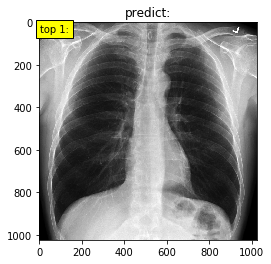

In [31]:
pred_str = str('')
path_image = '../pred/normal.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()